In [4]:
#!pip install catboost

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [6]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [7]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [8]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [9]:
train.shape

(26457, 20)

In [10]:
test.shape

(10000, 19)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# 데이터 전처리

## **1. 결측치 제거** 

In [12]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [13]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

## **2. Binary variables**

In [14]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


## **3. Continuous variable**

### (1) child_num

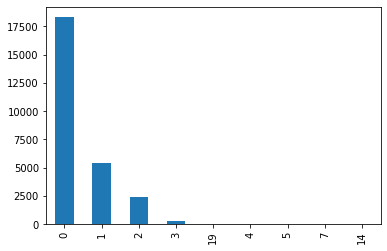

In [15]:
train['child_num'].value_counts(sort=False).plot.bar()

In [16]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

### (2) inc

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


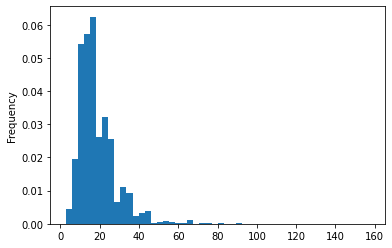

In [17]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000

print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [39]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]

train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [19]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,소득0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,2.0,-19.0
9996,36453,1,1,1,0,소득0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,2.0,-34.0
9997,36454,0,0,1,0,소득1,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,2.0,-55.0
9998,36455,0,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,2.0,-33.0


### **(3) Type**

In [20]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [41]:
# categorical data -> numerical data

from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])

train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])

train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])

train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

## **4. Minus continuous variable**

In [22]:
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [23]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [24]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [25]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,1,1,0,0,0,2.0,0,1.0
1,1,0,0,1,1,0,0,4,0,1,2,1,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,6,1,1,0,1,0,2.0,1,2.0
3,3,0,0,1,0,0,0,4,1,1,4,1,1,0,1,0,2.0,2,0.0
4,4,0,1,1,0,0,2,1,1,1,4,1,1,0,0,0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0,2,4,1,1,2,1,1,0,0,0,4.0,0,1.0
26453,26453,0,0,1,1,0,4,1,2,1,4,1,1,0,0,0,2.0,3,2.0
26454,26454,0,1,0,0,1,4,4,0,5,1,1,1,0,0,0,2.0,1,2.0
26455,26455,1,0,1,0,0,4,2,3,1,1,1,1,0,0,0,1.0,3,2.0


In [26]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,8,0,1,0,1,0,2.0,3
1,26458,0,0,1,0,0,2,1,1,1,6,1,1,0,1,0,2.0,2
2,26459,0,0,1,0,0,4,4,1,1,4,1,1,1,1,0,2.0,2
3,26460,1,1,0,0,0,0,4,1,1,6,1,1,1,0,0,2.0,2
4,26461,0,1,1,0,0,2,1,1,1,5,1,1,1,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,6,1,1,1,1,0,2.0,1
9996,36453,1,1,1,0,0,4,4,0,1,1,1,1,1,0,0,2.0,2
9997,36454,0,0,1,0,1,4,4,1,1,7,1,1,0,0,0,2.0,3
9998,36455,0,1,0,0,0,0,4,1,1,5,1,1,0,1,0,2.0,2


In [27]:
train.shape

(26457, 19)

In [28]:
test.shape

(10000, 18)

# 데이터 모델링

In [29]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [30]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 18) (26457, 1) (10000, 18)


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 3)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(21165, 18)
(21165, 1)
Validation set: 
(5292, 18)
(5292, 1)
log_loss: 1.0182555612390047


In [68]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.7865082674411985
FOLD 1 : logloss:0.7244043199006234
FOLD 2 : logloss:0.7464293339312248
FOLD 3 : logloss:0.8357364018152844
FOLD 4 : logloss:0.6674130307289649
Mean:0.7520982707634591


In [69]:
my_submission

array([[0.1, 0.5, 0.4],
       [0.1, 0.1, 0.8],
       [0. , 0.1, 0.9],
       ...,
       [0.1, 0.1, 0.8],
       [0. , 0.1, 0.9],
       [0. , 0.3, 0.7]])

In [70]:
submission

,index,0,1,2
0,26457,0.2,0.4,0.4
1,26458,0.0,0.8,0.2
2,26459,0.0,0.6,0.4
3,26460,0.2,0.2,0.6
4,26461,0.0,0.4,0.6
...,...,...,...,...
9995,36452,0.0,0.8,0.2
9996,36453,0.0,0.4,0.6
9997,36454,0.2,0.0,0.8
9998,36455,0.0,0.4,0.6


In [71]:
submission.loc[:,1:]=my_submission

In [72]:
submission

,index,0,1,2
0,26457,0.1,0.5,0.4
1,26458,0.1,0.1,0.8
2,26459,0.0,0.1,0.9
3,26460,0.1,0.1,0.8
4,26461,0.2,0.5,0.3
...,...,...,...,...
9995,36452,0.2,0.1,0.7
9996,36453,0.0,0.1,0.9
9997,36454,0.1,0.1,0.8
9998,36455,0.0,0.1,0.9


In [73]:
submission.to_csv('File.csv', index=False)